# 1D Gaussian Mixture

In [1]:

import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization
from tensorflow.keras.layers import Flatten, Reshape, Lambda
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

import os
import os.path as osp
import sys
sys.path.append('/home/jcollins')

import numpy as np
from scipy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

output_dir = './data/'

### Define VAE

In [558]:
def plot_latent_space_2(encoder, valid_data, xrange = [0.9,1e6]):
    latent_valid = np.array(encoder.predict(valid_data)[:3])
    perms = np.argsort(np.mean(latent_valid[1],axis=0))
    latent_valid = latent_valid[:,:,perms]
    
    #print(latent_valid.shape)
    plt.figure(figsize=(10,2.5))
    plt.subplot(1,2,1)
    
    
    
    plt.scatter(np.exp(-np.mean(latent_valid[1,:,:],axis=0)/2),np.sqrt(np.mean(np.square(latent_valid[0,:,:]),axis=0)),s=10.)
    plt.semilogx()
    plt.xlim(xrange)
    plt.ylim([0,2.])
    plt.ylabel(r'$\sqrt{<\mu^2>}$')
    plt.xlabel(r'$<\sigma>^{-1}$')
    
    plt.subplot(1,2,2)
    
    bins = np.logspace(np.log10(xrange[0]),np.log10(xrange[1]),50)

    plt.hist(np.sqrt(np.mean(np.square(latent_valid[0,:,:20]),axis=0) + np.exp(latent_valid[1,:,:20]))/np.exp(latent_valid[1,:,:20]/2),
         bins=bins,stacked=True)

    plt.xlabel("Inverse resolution")
    plt.semilogx()
    plt.xlim(xrange)
    plt.ylim([0,5e4])





    plt.show()

def plot_latent_space(encoder, valid_data, xrange = [0.9,1e6]):
    latent_valid = np.array(encoder.predict(valid_data)[:3])
    perms = np.argsort(np.mean(latent_valid[1],axis=0))
    latent_valid = latent_valid[:,:,perms]
    plt.figure(figsize=(18,4))

    plt.subplot(1,3,1)
    plt.hist(latent_valid[0,:,0],bins=np.arange(-5,5.00001,0.1),label="latent dimension 1",alpha=0.75)
    plt.hist(latent_valid[0,:,1],bins=np.arange(-5,5.00001,0.1),label="latent dimension 2",alpha=0.75)
    plt.title("latent means")
    plt.xlim([-5,5])
    plt.legend()
    
    plt.subplot(1,3,2)
    bins = np.logspace(-0.1,4,100)
    plt.hist(np.sqrt(np.mean(np.square(latent_valid[0,:,0])) + np.exp(latent_valid[1,:,0]))/np.exp(latent_valid[1,:,0]/2),label="latent dimension 1",alpha=0.75,bins=bins)
    plt.hist(np.sqrt(np.mean(np.square(latent_valid[0,:,1])) + np.exp(latent_valid[1,:,1]))/np.exp(latent_valid[1,:,1]/2),label="latent dimension 2",alpha=0.75,bins=bins)
    plt.title("Inverse resolution")
    plt.semilogx()
    plt.xlim(xrange)
    plt.legend()



    plt.subplot(1,3,3)
    plt.hist(latent_valid[2,:,0],bins=np.arange(-5,5.00001,0.1),label="latent dimension 1",alpha=0.75)
    plt.hist(latent_valid[2,:,1],bins=np.arange(-5,5.00001,0.1),label="latent dimension 2",alpha=0.75)
    plt.title("sampled z")
    plt.xlim([-5,5])
    plt.legend()

    plt.show()
    
def plot_latent_map(encoder, decoder, train_data_banana,
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3]):
    
    
    
    scales = np.array(scales)
    values = np.array(values)
    numpoints = 100
    ranges = scales[:,1]-scales[:,0]

    latent_valid_mu, latent_valid_logvar, latent_valid = np.array(encoder.predict(train_data_banana))
    perms = np.argsort(np.mean(latent_valid_logvar,axis=0))
    
    codes1_proj = np.array([np.vstack([np.ones(numpoints)*value,np.linspace(scales[0,0],scales[0,1],numpoints)]).T for value in values[0]])
    codes2_proj = np.array([np.vstack([np.linspace(scales[1,0],scales[1,1],numpoints),np.ones(numpoints)*value]).T for value in values[1]])

    codes1 = np.zeros((3,numpoints,10))
    codes1[:,:,perms[0]] = codes2_proj[:,:,0]
    codes1[:,:,perms[1]] = codes2_proj[:,:,1]
    codes2 = np.zeros((3,numpoints,10))
    codes2[:,:,perms[0]] = codes1_proj[:,:,0]
    codes2[:,:,perms[1]] = codes1_proj[:,:,1]
#     if long_axis == 0:
#         codes0 = np.array([[code,short_values[0]] for code in codes])
#         codes1 = np.array([[code,short_values[1]] for code in codes])
#         codes2 = np.array([[code,short_values[2]] for code in codes])
#     else:
#         codes0 = np.array([[short_values[0],code] for code in codes])
#         codes1 = np.array([[short_values[1],code] for code in codes])
#         codes2 = np.array([[short_values[2],code] for code in codes])

    fig, ax = plt.subplots(1,2,figsize=(12,3.5),gridspec_kw={'width_ratios': [1, 2]})
    

    
    ax[0].scatter(latent_valid[:,perms[0]],latent_valid[:,perms[1]],color='gray',alpha=0.1,s=0.4)
    ax[1].scatter(train_data_banana[:,0],train_data_banana[:,1],color='gray',alpha=0.1,s=0.4)

    cmap = matplotlib.cm.get_cmap('cool')
    
    for i,codes in enumerate(codes1):
#         points = np.zeros((numpoints,2))
        color = cmap(i/3.)
        points = decoder.predict(codes)
        ax[1].plot(points[:,0],points[:,1],color = color)
        ax[0].plot(codes[:,perms[0]],codes[:,perms[1]],color = color)
        
    cmap = matplotlib.cm.get_cmap('autumn')
    
    for i,codes in enumerate(codes2):
        color = cmap(i/3.)
        points = decoder.predict(codes)
        ax[1].plot(points[:,0],points[:,1],color = color)
        ax[0].plot(codes[:,perms[0]],codes[:,perms[1]],color = color)

#     points = np.zeros((int(long_range/0.01),2))
#     points = decoder.predict(codes1)
#     plt.scatter(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[1])),s=0.5)

#     points = np.zeros((int(long_range/0.01),2))
#     points = decoder.predict(codes2)
# #     plt.scatter(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[2])),s=0.5)
#     plt.plot(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[2])))
    ax[1].set_xlim([-2.5,2.5])
    ax[1].set_ylim([-0.75,1.75])
    ax[0].set_xlim(latent_plotrange)
    ax[0].set_ylim(latent_plotrange)
    #plt.legend()

    plt.show()

## Generate training data

Input data is 2D, generated in the shape of a banana (plotted below) defined by two gaussians with widths 1 and 0.1. The VAE will be tasked with reconstructing the 2D location of the input points, using euclidean distance as the reconstruction error. The latent space is 2D, so can in principle easily encode everything about the input. This will be regulated by the variational latent space

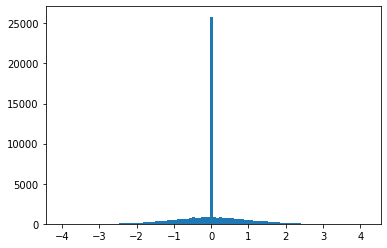

In [412]:
numtrain = 500000
numvalid = 50000

train_data = np.append(np.random.normal(scale=1,size=(int(numtrain/2),1)),
                       np.random.normal(scale=1e-2,size=(int(numtrain/2),1)),axis=-2)

valid_data = np.append(np.random.normal(scale=1,size=(int(numvalid/2),1)),
                       np.random.normal(scale=1e-2,size=(int(numvalid/2),1)),axis=-2)

np.random.shuffle(valid_data)
np.random.shuffle(train_data)

plt.hist(valid_data[:,0],bins=100)
# plt.xlim([-4,4])
# plt.ylim([-0.5,3])
plt.show()

In [5]:
K.sigmoid

<function tensorflow.python.keras.backend.sigmoid>

# Beta annealing

The idea is to start training at very small beta, so the VAE learns to encode a poorly regulated but high-information encoding of the information into the latent space. As you then increase beta, the latent directions become well regulated and begin to align with axes of variance present in the training dataset. Dimensions will only be forgetten when beta truly crosses over the threshold of marginality.

In [452]:
Activations

NameError: name 'Activations' is not defined

In [512]:
# https://arxiv.org/pdf/1611.00712.pdf

def build_and_compile_annealing_vae(encoder_layers = [512,256,256,256,256],
                                    decoder = [512,256,256,256],
                                    verbose=0,dropout=0,
                                    optimizer=keras.optimizers.Adam()):
    
    temp = 0.3
    EPSILON = 1e-6
    #renorm_clipping={'rmax':3., 'rmin':1./3, 'dmax':5.}
    renorm_clipping = None
    momentum = 0.99
    
    def sampling_gauss(args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.

        # Arguments
            args (tensor): mean and log of variance of Q(z|X)

        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    def sampling_bern(theta):

        batch = K.shape(theta)[0]
        dim = K.int_shape(theta)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_uniform(shape=(batch, dim),maxval=1-EPSILON,minval=EPSILON)
        #return (K.log(epsilon) - K.log(1-epsilon) + K.log(theta+EPSILON) - K.log(1-theta+EPSILON))/temp
        return (K.log(epsilon) - K.log(1-epsilon) + K.log(theta+EPSILON))/temp
    
    real_dim = 1
    latent_dim = 5
    cat_dim = 2
    
    #Encoder
    inputs = tf.keras.Input(shape=(real_dim,))
    beta_input = tf.keras.Input(shape=(1,))
    alpha_input = tf.keras.Input(shape=(1,))
#     layer = inputs
    layer = tf.keras.layers.Concatenate()([inputs,beta_input,alpha_input])
    layer = Lambda(lambda x: x[:,:real_dim])(layer)
    for layer_size in encoder_layers[:-2]:
        layer = Dense(layer_size,bias_initializer='glorot_uniform')(layer)
        layer = BatchNormalization(renorm=True,
                                     renorm_clipping=renorm_clipping,
                                     momentum = momentum,
                                     renorm_momentum=momentum)(layer)
        layer = keras.layers.ReLU()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)
        

    #Bottleneck
    alpha_bern = Dense(cat_dim, name='alpha_bern')(layer)
#     alpha_bern = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = 0.999,
#                                      renorm_momentum=0.999)(alpha_bern)
    alpha_bern = keras.layers.ELU()(alpha_bern)
    alpha_bern = keras.layers.Lambda(lambda x: x + 1)(alpha_bern)
#     alpha_bern = Activation('sigmoid')(alpha_bern)


    z_bern = Lambda(sampling_bern, output_shape=(cat_dim,), name='z_bern')(alpha_bern)
    z_bern_sigmoid = Activation('sigmoid')(z_bern)
    
    layer = tf.keras.layers.Concatenate()([layer,z_bern_sigmoid])
    layer = Dense(encoder_layers[-2],bias_initializer='glorot_uniform')(layer)
    layer = BatchNormalization(renorm=True,
                                 renorm_clipping=renorm_clipping,
                                 momentum = momentum,
                                 renorm_momentum=momentum)(layer)
    layer = keras.layers.ReLU()(layer)
    layer = Dense(encoder_layers[-1],bias_initializer='glorot_uniform')(layer)
    layer = BatchNormalization(renorm=True,
                                 renorm_clipping=renorm_clipping,
                                 momentum = momentum,
                                 renorm_momentum=momentum)(layer)
    layer = keras.layers.ReLU()(layer)
    
    
    z_mean = Dense(latent_dim, name='z_mean')(layer)
    z_log_var = Dense(latent_dim, name='z_log_var')(layer)
    z = Lambda(sampling_gauss, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model([inputs,beta_input,alpha_input], [z_mean, z_log_var, z, alpha_bern, z_bern_sigmoid], name='encoder')
    if verbose:
        encoder.summary()
    #plot_model(encoder, to_file='CNN-VAE_encoder.png', show_shapes=True)

    #Decoder
    latent_inputs_gauss = Input(shape=(latent_dim,), name='z_sampling')
    latent_inputs_bern = Input(shape=(cat_dim,), name='z_sampling_bern')
    layer = tf.keras.layers.Concatenate()([latent_inputs_gauss,latent_inputs_bern])
    #layer = latent_inputs
    
    for i, layer_size in enumerate(decoder):
        layer = Dense(layer_size,bias_initializer='glorot_uniform')(layer)
        layer = BatchNormalization(renorm=True,
                                     renorm_clipping=renorm_clipping,
                                     momentum = momentum,
                                     renorm_momentum=momentum)(layer)
        layer = keras.layers.ReLU()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)
            
    decoded = Dense(real_dim)(layer)

    decoder = Model([latent_inputs_gauss,latent_inputs_bern], decoded, name='decoder')
    if verbose:
        decoder.summary()
    #plot_model(decoder, to_file='CNN-VAE_decoder.png', show_shapes=True)


    outputs = decoder([encoder([inputs,beta_input,alpha_input])[2], encoder([inputs,beta_input,alpha_input])[4]])
    vae = Model([inputs,beta_input,alpha_input], outputs, name='CNN-VAE')

    def myfunc(alpha, x,temp=temp):
        #return (temp*alpha*K.pow(x,-temp-1)*K.pow(1-x,-temp-1))/K.square(alpha*K.pow(x,-temp) + K.pow(1-x,-temp))
        return K.log(temp) - temp*x + K.log(alpha + EPSILON) - 2*K.log(1+alpha*K.exp(-temp*x ))
        #return K.log(alpha + EPSILON) - 2*K.log(1+alpha*K.exp(-temp*x ))

    def beta_vae_loss(beta, alpha):
        def vae_loss(x, x_decoded_mean):
            #xent_loss = K.sqrt(K.sum(K.square(x - x_decoded_mean),axis=-1))
            xent_loss = K.sum(K.square(x - x_decoded_mean),axis=-1)
            p_alpha = alpha_bern/(1+alpha_bern)
            #p_alpha = alpha_bern
            kl_loss_bern = K.sum(p_alpha*K.log(p_alpha/0.5+EPSILON) + (1-p_alpha)*K.log((1-p_alpha)/0.5+EPSILON),axis=-1)
            kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return K.mean(xent_loss/beta**2 + kl_loss + alpha* kl_loss_bern)
        return vae_loss
    
    def recon_loss(x, x_decoded_mean):
        recon_loss = K.sum(K.square(x - x_decoded_mean),axis=-1)
        return K.mean(recon_loss)
    
    def kl_loss(beta):
        def get_kl_loss(x, x_decoded_mean):
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return K.mean( kl_loss)
        return get_kl_loss
    
    def kl_loss_bern(beta):
        def get_kl_loss_bern(x, x_decoded_mean):
            p_alpha = alpha_bern/(1+alpha_bern)
            #p_alpha = alpha_bern
            kl_loss = K.sum(p_alpha*K.log(p_alpha/0.5+EPSILON) + (1-p_alpha)*K.log((1-p_alpha)/0.5+EPSILON),axis=-1)
            return K.mean( kl_loss)
        return get_kl_loss_bern
    
    vae.compile(loss=beta_vae_loss(beta_input, alpha_input),
                optimizer=optimizer,
                metrics = [recon_loss,kl_loss(beta_input), kl_loss_bern(beta_input)]
               )
    
    vae.summary()
    
    return vae, encoder, decoder
experiment_name = 'banana_bern_test'
train_output_dir = create_dir(osp.join(output_dir, experiment_name))

save_period = 2
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}.hdf5', period = save_period)
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

callbacks = [modelcheckpoint,reduceLR,earlystop]

class encoder_class():
    def __init__(self,encoder):
        self.encoder = encoder
        
    def predict(self, data):
        return self.encoder.predict([data,np.ones(len(data)),np.ones(len(data))])

In [509]:
experiment_name = 'bern_test'
vae, encoder, decoder = build_and_compile_annealing_vae(encoder_layers = [512,256,128,128,128],
                                                        decoder = [512,256,128,128],
                                                        optimizer=keras.optimizers.Adam(lr=0.001,clipnorm=0.1))



Model: "CNN-VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_90 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_91 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_92 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 5), (None, 5 206998      input_90[0][0]                   
                                                                 input_91[0][0]             

In [ ]:
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=0)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks = [modelcheckpoint,
    reduceLR,earlystop]

beta = 1e-1
alpha = 1.0
K.set_value(vae.optimizer.lr,1e-5)
epochs = 1000
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta,np.ones(len(train_data))*alpha], y=train_data, batch_size=1000,
                epochs=epochs,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = ([valid_data,np.ones(len(valid_data))*beta,np.ones(len(valid_data))*alpha],valid_data),
                callbacks = callbacks
              )

# tf.saved_model.save(vae, train_output_dir + '/mymodel.hdf5')

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 44s 89us/sample - loss: 3.6149 - recon_loss: 0.0209 - get_kl_loss: 0.9405 - get_kl_loss_bern: 0.5823 - val_loss: 3.2890 - val_recon_loss: 0.0169 - val_get_kl_loss: 1.0149 - val_get_kl_loss_bern: 0.5819
Epoch 2/1000
500000/500000 [==============================] - 42s 84us/sample - loss: 3.4512 - recon_loss: 0.0180 - get_kl_loss: 1.0668 - get_kl_loss_bern: 0.5820 - val_loss: 3.2053 - val_recon_loss: 0.0159 - val_get_kl_loss: 1.0340 - val_get_kl_loss_bern: 0.5821
Epoch 3/1000
500000/500000 [==============================] - 42s 84us/sample - loss: 3.2990 - recon_loss: 0.0162 - get_kl_loss: 1.0956 - get_kl_loss_bern: 0.5836 - val_loss: 3.1187 - val_recon_loss: 0.0144 - val_get_kl_loss: 1.0960 - val_get_kl_loss_bern: 0.5842
Epoch 4/1000
500000/500000 [==============================] - 41s 82us/sample - loss: 3.1670 - recon_loss: 0.0147 - get_kl_loss: 1.1155 - get_kl_loss_bern: 0

Latent space encoding for beta = 0.3 :


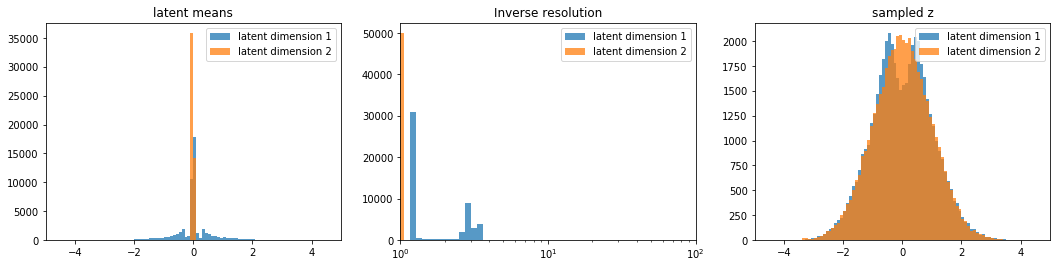

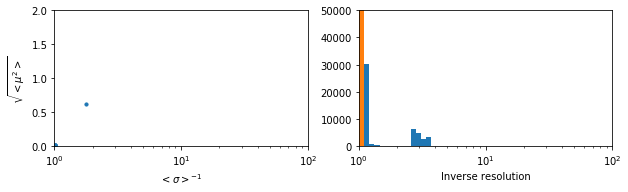

In [727]:
print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data,xrange = [1,1e2])
plot_latent_space_2(myencoder,valid_data,xrange = [1,1e2])

In [728]:
myencoder = encoder_class(encoder)
z_mu, z_logvar, z, theta, sig = myencoder.predict(valid_data)

In [729]:
np.std(theta,axis=0)

array([ 0.03242359, 11.086048  ], dtype=float32)

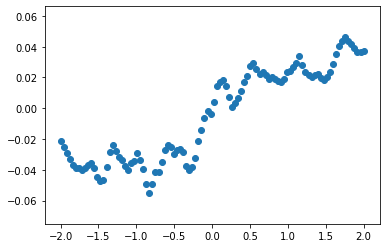

In [730]:
perms = np.argsort(np.mean(z_logvar,axis=0))
codes = np.linspace(-2,2,100)
codesarray = np.zeros((100,7))
codesarray[:,perms[0]] = codes
codesarray[:,-1] = np.ones(100)*0
codesarray[:,-2] = np.ones(100)*1
decodes = decoder.predict([codesarray[:,:5],codesarray[:,5:]])
plt.scatter(codes,decodes)
plt.show()

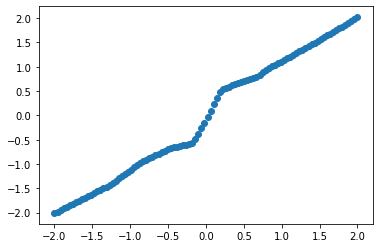

In [731]:
perms = np.argsort(np.mean(z_logvar,axis=0))
codes = np.linspace(-2,2,100)
codesarray = np.zeros((100,7))
codesarray[:,perms[0]] = codes
codesarray[:,-1] = np.ones(100)
decodes = decoder.predict([codesarray[:,:5],codesarray[:,5:]])
plt.scatter(codes,decodes)
plt.show()

In [732]:
perms = np.argsort(np.mean(z_logvar,axis=0))
print(np.mean(sig,axis=-2))
print(np.var(thetas,axis=-2))

[0.50137144 0.3151241 ]
[44.12304]


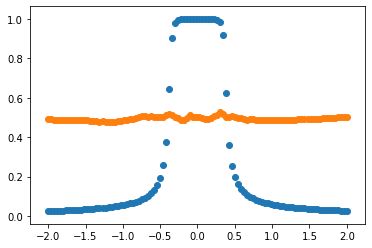

In [733]:
myencoder = encoder_class(encoder)
coords = np.linspace(-2,2,100)
codes = 1/(1+myencoder.predict(coords)[-2][:,-1])
plt.scatter(coords,codes)
codes = 1/(1+myencoder.predict(coords)[-2][:,-2])
plt.scatter(coords,codes)


In [ ]:
plt.scatter(z_mu[:,perms[0]],z_logvar[:,perms[0]])

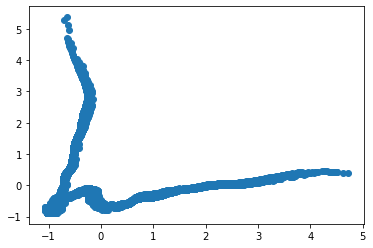

In [285]:
plt.scatter(z_mu[:,perms[0]],z_mu[:,perms[1]])

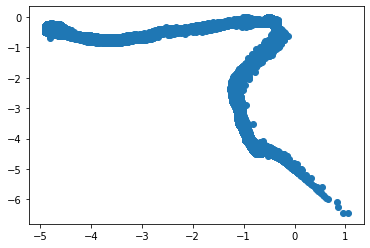

In [286]:
plt.scatter(z_logvar[:,perms[0]],z_logvar[:,perms[1]])

In [287]:
codes = np.arange(-4,4,0.1)

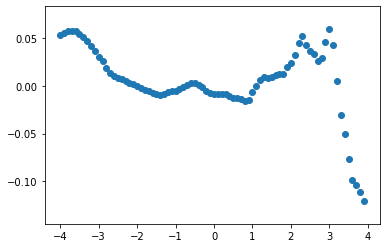

In [288]:
input_codes = np.zeros((len(codes),10))
input_codes[:,perms[1]] = codes
input_codes[:,5:] = np.ones((len(codes),5))*1.2
output = decoder.predict([input_codes[:,:5],input_codes[:,5:]])
plt.scatter(codes,output)
plt.show()

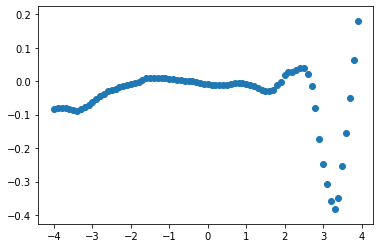

In [289]:
input_codes = np.zeros((len(codes),10))
input_codes[:,perms[0]] = codes
input_codes[:,5:] = np.ones((len(codes),5))*1.2
output = decoder.predict([input_codes[:,:5],input_codes[:,5:]])
plt.scatter(codes,output)
plt.show()

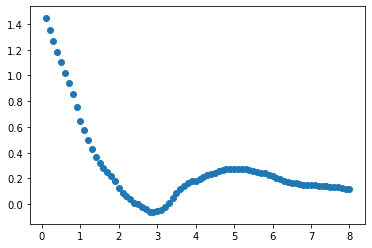

In [301]:
codes_2 = np.arange(0.1,8.1,0.1)
input_codes = np.ones((len(codes),10))*3.
input_codes[:,5:] = np.ones((len(codes),5))*1.
input_codes[:,7] = codes_2
output = decoder.predict([input_codes[:,:5],input_codes[:,5:]])
plt.scatter(codes_2,output)
plt.show()

In [296]:
input_codes

array([[0. , 0. , 0. , 0. , 0. , 1. , 1. , 0.1, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 0.2, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 0.3, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 0.4, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 0.5, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 0.6, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 0.7, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 0.8, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 0.9, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 1.1, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 1.2, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 1.3, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 1.4, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 1.5, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 1.6, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 1. , 1.7, 1. , 1. 

In [269]:
print(np.mean(z_thetas,axis=-2))
print(np.var(thetas,axis=-2))

array([0.5064778 , 0.49462134, 0.506818  , 0.5073254 , 0.5045588 ],
      dtype=float32)

In [270]:
np.var(thetas,axis=-2)

array([0.02749179, 0.00668953, 0.04243988, 0.03619491, 0.00423002],
      dtype=float32)

(array([4.145e+04, 4.151e+03, 1.933e+03, 1.211e+03, 6.920e+02, 3.520e+02,
        1.490e+02, 4.900e+01, 1.000e+01, 3.000e+00]),
 array([ 0.6599205,  1.8586309,  3.0573413,  4.2560515,  5.454762 ,
         6.6534724,  7.852183 ,  9.050893 , 10.249603 , 11.448314 ,
        12.647024 ], dtype=float32),
 <a list of 10 Patch objects>)

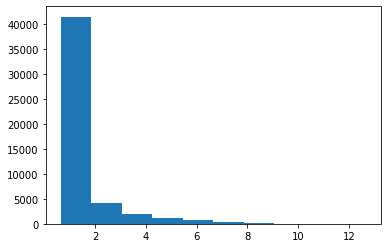

In [166]:
plt.hist(thetas[:,2])

(array([ 6373.,   683.,   581.,   482.,  3602.,  3793.,  4709., 26897.,
          818.,  2062.]),
 array([0.30404985, 0.40753055, 0.51101124, 0.614492  , 0.7179727 ,
        0.8214534 , 0.9249341 , 1.0284148 , 1.1318955 , 1.2353762 ,
        1.3388569 ], dtype=float32),
 <a list of 10 Patch objects>)

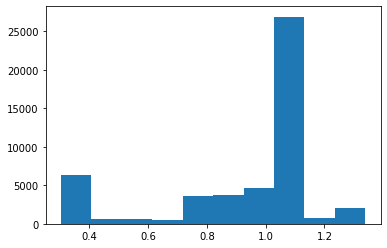

In [167]:
plt.hist(thetas[:,0])

In [25]:
perms = np.argsort(np.mean(z_logvar,axis=-2))

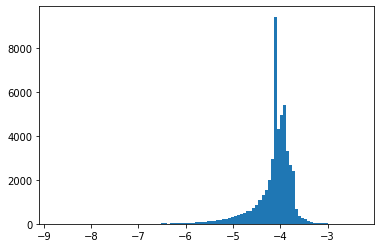

In [164]:
plt.hist(z_logvar[:,perms[0]], bins = 100)
plt.show()

In [ ]:
print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data,xrange = [0.9,1e4])

In [ ]:
perms = np.argsort(np.mean(z_logvar,axis=-2))
plt.hist(z_mu[:,perms[0]], bins = 100)
plt.show()

In [21]:
betas = np.array([1e-1,2e-1,4e-1,6e-1,7e-1,8e-1,9e-1,1.,1.1,1.2,1.3,1.4,2.])
sigmas = np.zeros(len(betas))

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 41s 81us/sample - loss: 31.6796 - recon_loss: 0.0518 - get_kl_loss: 26.4970 - val_loss: 31.6710 - val_recon_loss: 0.0516 - val_get_kl_loss: 26.5139
Epoch 2/1000
500000/500000 [==============================] - 39s 77us/sample - loss: 31.6787 - recon_loss: 0.0518 - get_kl_loss: 26.5006 - val_loss: 31.6344 - val_recon_loss: 0.0510 - val_get_kl_loss: 26.5346
Epoch 3/1000
500000/500000 [==============================] - 44s 87us/sample - loss: 31.6685 - recon_loss: 0.0517 - get_kl_loss: 26.4941 - val_loss: 31.6272 - val_recon_loss: 0.0514 - val_get_kl_loss: 26.4913
Epoch 4/1000
499400/500000 [============================>.] - ETA: 0s - loss: 31.6621 - recon_loss: 0.0517 - get_kl_loss: 26.4927
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
500000/500000 [==============================] - 40s 80us/sample - loss: 31.6623 - recon_loss: 0.0517 - get_k

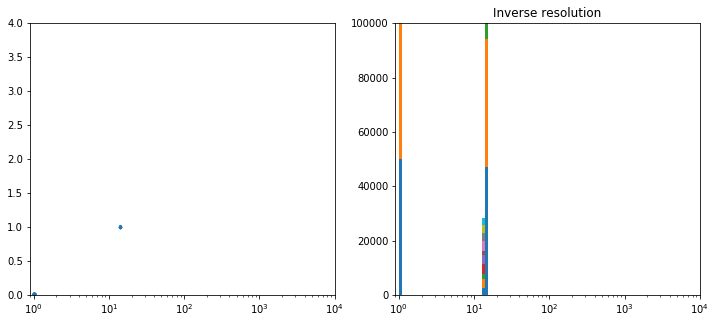

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 41s 82us/sample - loss: 24.6735 - recon_loss: 0.1994 - get_kl_loss: 19.6873 - val_loss: 24.6380 - val_recon_loss: 0.2019 - val_get_kl_loss: 19.5911
Epoch 2/1000
500000/500000 [==============================] - 41s 82us/sample - loss: 24.6328 - recon_loss: 0.2024 - get_kl_loss: 19.5726 - val_loss: 24.6529 - val_recon_loss: 0.2057 - val_get_kl_loss: 19.5115
Epoch 3/1000
499800/500000 [============================>.] - ETA: 0s - loss: 24.6298 - recon_loss: 0.2027 - get_kl_loss: 19.5618
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
500000/500000 [==============================] - 37s 74us/sample - loss: 24.6297 - recon_loss: 0.2027 - get_kl_loss: 19.5619 - val_loss: 24.6370 - val_recon_loss: 0.2028 - val_get_kl_loss: 19.5664
Epoch 4/1000
500000/500000 [==============================] - 39s 77us/sample - loss: 24.5979 - recon_loss: 0.2012 - get_k

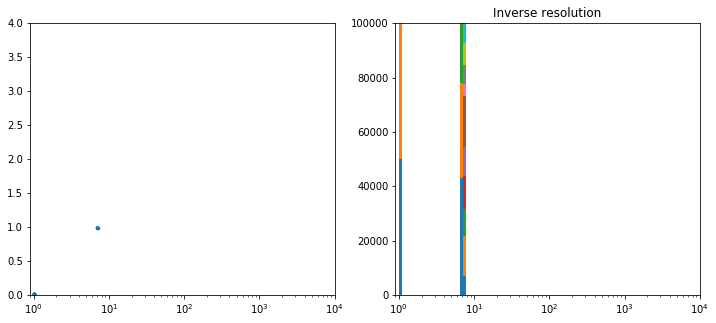

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 36s 72us/sample - loss: 17.6999 - recon_loss: 0.7922 - get_kl_loss: 12.7490 - val_loss: 17.6716 - val_recon_loss: 0.8094 - val_get_kl_loss: 12.6130
Epoch 2/1000
500000/500000 [==============================] - 36s 72us/sample - loss: 17.6650 - recon_loss: 0.8044 - get_kl_loss: 12.6375 - val_loss: 17.6583 - val_recon_loss: 0.8148 - val_get_kl_loss: 12.5659
Epoch 3/1000
500000/500000 [==============================] - 38s 75us/sample - loss: 17.6602 - recon_loss: 0.8049 - get_kl_loss: 12.6296 - val_loss: 17.6481 - val_recon_loss: 0.8093 - val_get_kl_loss: 12.5901
Epoch 4/1000
500000/500000 [==============================] - 37s 75us/sample - loss: 17.6625 - recon_loss: 0.8055 - get_kl_loss: 12.6283 - val_loss: 17.6597 - val_recon_loss: 0.8064 - val_get_kl_loss: 12.6197
Epoch 5/1000
500000/500000 [==============================] - 39s 78us/sample - loss: 17.6564 - recon_loss: 0

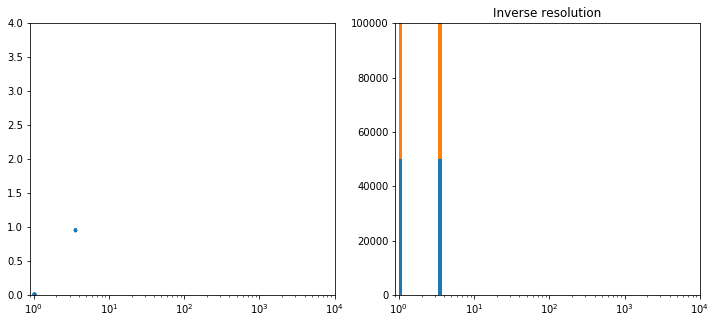

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 36s 72us/sample - loss: 13.6037 - recon_loss: 1.7862 - get_kl_loss: 8.6421 - val_loss: 13.5933 - val_recon_loss: 1.8070 - val_get_kl_loss: 8.5739
Epoch 2/1000
500000/500000 [==============================] - 37s 73us/sample - loss: 13.5957 - recon_loss: 1.8061 - get_kl_loss: 8.5787 - val_loss: 13.6162 - val_recon_loss: 1.8355 - val_get_kl_loss: 8.5175
Epoch 3/1000
500000/500000 [==============================] - 36s 72us/sample - loss: 13.5943 - recon_loss: 1.8077 - get_kl_loss: 8.5729 - val_loss: 13.5911 - val_recon_loss: 1.8008 - val_get_kl_loss: 8.5887
Epoch 4/1000
500000/500000 [==============================] - 36s 73us/sample - loss: 13.5944 - recon_loss: 1.8076 - get_kl_loss: 8.5732 - val_loss: 13.6001 - val_recon_loss: 1.8003 - val_get_kl_loss: 8.5993
Epoch 5/1000
500000/500000 [==============================] - 37s 74us/sample - loss: 13.5953 - recon_loss: 1.8081 - 

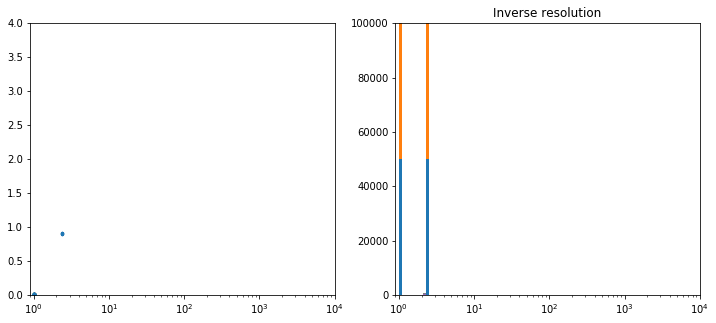

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 59s 117us/sample - loss: 12.0500 - recon_loss: 2.4458 - get_kl_loss: 7.0586 - val_loss: 12.0581 - val_recon_loss: 2.4643 - val_get_kl_loss: 7.0289
Epoch 2/1000
500000/500000 [==============================] - 42s 83us/sample - loss: 12.0460 - recon_loss: 2.4590 - get_kl_loss: 7.0276 - val_loss: 12.0417 - val_recon_loss: 2.4804 - val_get_kl_loss: 6.9795
Epoch 3/1000
500000/500000 [==============================] - 43s 87us/sample - loss: 12.0456 - recon_loss: 2.4589 - get_kl_loss: 7.0276 - val_loss: 12.0463 - val_recon_loss: 2.4518 - val_get_kl_loss: 7.0426
Epoch 4/1000
500000/500000 [==============================] - 47s 93us/sample - loss: 12.0423 - recon_loss: 2.4576 - get_kl_loss: 7.0267 - val_loss: 12.0252 - val_recon_loss: 2.4649 - val_get_kl_loss: 6.9947
Epoch 5/1000
500000/500000 [==============================] - 49s 98us/sample - loss: 12.0483 - recon_loss: 2.4597 -

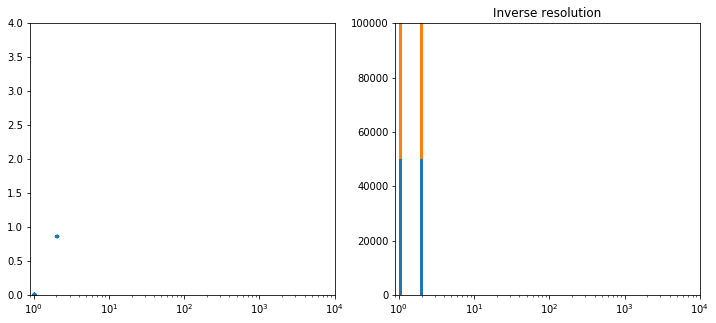

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 49s 98us/sample - loss: 10.7061 - recon_loss: 3.1900 - get_kl_loss: 5.7217 - val_loss: 10.6911 - val_recon_loss: 3.2034 - val_get_kl_loss: 5.6858
Epoch 2/1000
500000/500000 [==============================] - 49s 98us/sample - loss: 10.7052 - recon_loss: 3.2087 - get_kl_loss: 5.6916 - val_loss: 10.6960 - val_recon_loss: 3.2050 - val_get_kl_loss: 5.6881
Epoch 3/1000
499700/500000 [============================>.] - ETA: 0s - loss: 10.7085 - recon_loss: 3.2104 - get_kl_loss: 5.6923
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
500000/500000 [==============================] - 50s 100us/sample - loss: 10.7088 - recon_loss: 3.2105 - get_kl_loss: 5.6924 - val_loss: 10.7014 - val_recon_loss: 3.1963 - val_get_kl_loss: 5.7071
Epoch 4/1000
500000/500000 [==============================] - 53s 107us/sample - loss: 10.7083 - recon_loss: 3.2055 - get_kl_los

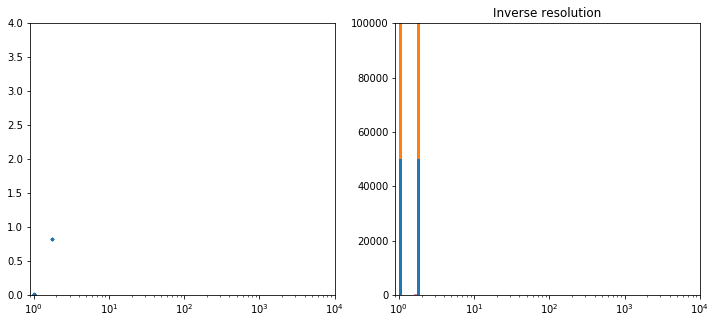

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 37s 74us/sample - loss: 9.5311 - recon_loss: 4.0306 - get_kl_loss: 4.5550 - val_loss: 9.5516 - val_recon_loss: 4.0858 - val_get_kl_loss: 4.5075
Epoch 2/1000
500000/500000 [==============================] - 37s 73us/sample - loss: 9.5300 - recon_loss: 4.0581 - get_kl_loss: 4.5200 - val_loss: 9.5237 - val_recon_loss: 4.0299 - val_get_kl_loss: 4.5485
Epoch 3/1000
500000/500000 [==============================] - 37s 74us/sample - loss: 9.5265 - recon_loss: 4.0605 - get_kl_loss: 4.5135 - val_loss: 9.5253 - val_recon_loss: 4.0727 - val_get_kl_loss: 4.4973
Epoch 4/1000
500000/500000 [==============================] - 37s 74us/sample - loss: 9.5231 - recon_loss: 4.0596 - get_kl_loss: 4.5112 - val_loss: 9.5205 - val_recon_loss: 4.0937 - val_get_kl_loss: 4.4666
Epoch 5/1000
500000/500000 [==============================] - 37s 73us/sample - loss: 9.5313 - recon_loss: 4.0628 - get_kl_lo

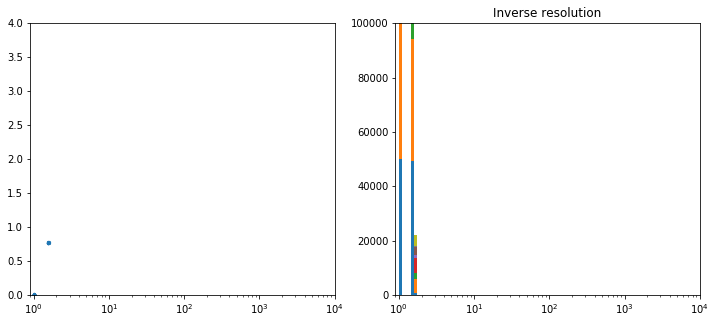

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 56s 112us/sample - loss: 8.4724 - recon_loss: 4.9643 - get_kl_loss: 3.5082 - val_loss: 8.4516 - val_recon_loss: 5.0264 - val_get_kl_loss: 3.4252
Epoch 2/1000
500000/500000 [==============================] - 55s 110us/sample - loss: 8.4695 - recon_loss: 5.0082 - get_kl_loss: 3.4613 - val_loss: 8.4574 - val_recon_loss: 5.0068 - val_get_kl_loss: 3.4506
Epoch 3/1000
499800/500000 [============================>.] - ETA: 0s - loss: 8.4696 - recon_loss: 5.0130 - get_kl_loss: 3.4566
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
500000/500000 [==============================] - 55s 110us/sample - loss: 8.4698 - recon_loss: 5.0131 - get_kl_loss: 3.4567 - val_loss: 8.4707 - val_recon_loss: 5.0130 - val_get_kl_loss: 3.4577
Epoch 4/1000
500000/500000 [==============================] - 46s 93us/sample - loss: 8.4665 - recon_loss: 5.0065 - get_kl_loss: 3.45

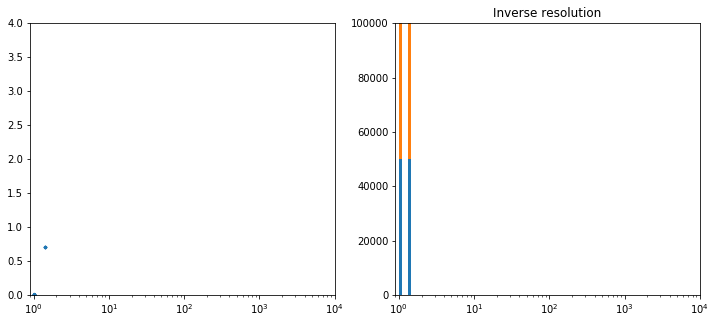

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 40s 79us/sample - loss: 7.5194 - recon_loss: 5.9857 - get_kl_loss: 2.5726 - val_loss: 7.5066 - val_recon_loss: 6.0808 - val_get_kl_loss: 2.4811
Epoch 2/1000
500000/500000 [==============================] - 42s 83us/sample - loss: 7.5179 - recon_loss: 6.0611 - get_kl_loss: 2.5087 - val_loss: 7.5065 - val_recon_loss: 6.0508 - val_get_kl_loss: 2.5059
Epoch 3/1000
499400/500000 [============================>.] - ETA: 0s - loss: 7.5196 - recon_loss: 6.0634 - get_kl_loss: 2.5086
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
500000/500000 [==============================] - 41s 82us/sample - loss: 7.5194 - recon_loss: 6.0632 - get_kl_loss: 2.5085 - val_loss: 7.5168 - val_recon_loss: 6.0833 - val_get_kl_loss: 2.4893
Epoch 4/1000
500000/500000 [==============================] - 42s 85us/sample - loss: 7.5124 - recon_loss: 6.0530 - get_kl_loss: 2.5099 

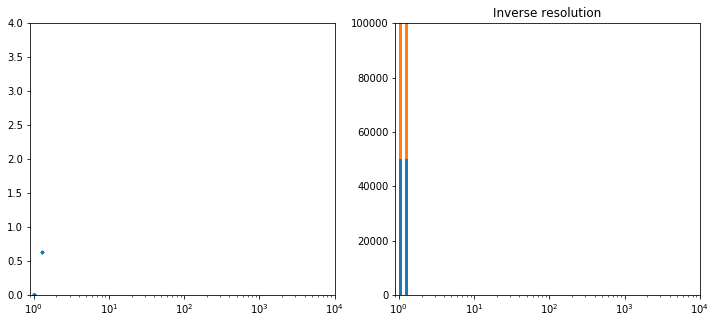

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 39s 79us/sample - loss: 6.6507 - recon_loss: 7.0746 - get_kl_loss: 1.7378 - val_loss: 6.6281 - val_recon_loss: 7.1634 - val_get_kl_loss: 1.6535
Epoch 2/1000
500000/500000 [==============================] - 39s 78us/sample - loss: 6.6469 - recon_loss: 7.2059 - get_kl_loss: 1.6428 - val_loss: 6.6476 - val_recon_loss: 7.2072 - val_get_kl_loss: 1.6426
Epoch 3/1000
499300/500000 [============================>.] - ETA: 0s - loss: 6.6447 - recon_loss: 7.2096 - get_kl_loss: 1.6381
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
500000/500000 [==============================] - 41s 82us/sample - loss: 6.6444 - recon_loss: 7.2093 - get_kl_loss: 1.6380 - val_loss: 6.6413 - val_recon_loss: 7.2256 - val_get_kl_loss: 1.6235
Epoch 4/1000
500000/500000 [==============================] - 43s 86us/sample - loss: 6.6424 - recon_loss: 7.2139 - get_kl_loss: 1.6327 

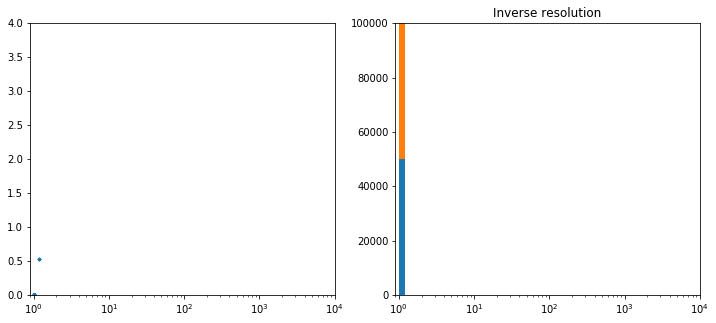

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 39s 78us/sample - loss: 5.8483 - recon_loss: 8.1752 - get_kl_loss: 1.0109 - val_loss: 5.8408 - val_recon_loss: 8.3880 - val_get_kl_loss: 0.8775
Epoch 2/1000
500000/500000 [==============================] - 37s 74us/sample - loss: 5.8447 - recon_loss: 8.4335 - get_kl_loss: 0.8545 - val_loss: 5.8368 - val_recon_loss: 8.4486 - val_get_kl_loss: 0.8376
Epoch 3/1000
500000/500000 [==============================] - 37s 73us/sample - loss: 5.8433 - recon_loss: 8.4516 - get_kl_loss: 0.8423 - val_loss: 5.8373 - val_recon_loss: 8.4425 - val_get_kl_loss: 0.8418
Epoch 4/1000
500000/500000 [==============================] - 36s 72us/sample - loss: 5.8444 - recon_loss: 8.4575 - get_kl_loss: 0.8400 - val_loss: 5.8359 - val_recon_loss: 8.4451 - val_get_kl_loss: 0.8388
Epoch 5/1000
500000/500000 [==============================] - 36s 73us/sample - loss: 5.8411 - recon_loss: 8.4537 - get_kl_lo

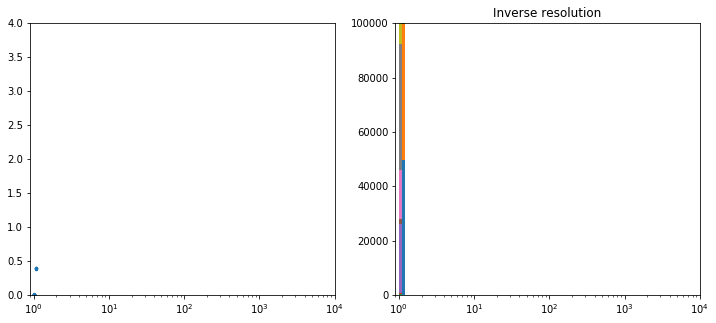

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 35s 71us/sample - loss: 5.1185 - recon_loss: 9.1869 - get_kl_loss: 0.4313 - val_loss: 5.1007 - val_recon_loss: 9.4182 - val_get_kl_loss: 0.2955
Epoch 2/1000
500000/500000 [==============================] - 35s 70us/sample - loss: 5.1038 - recon_loss: 9.5270 - get_kl_loss: 0.2431 - val_loss: 5.1025 - val_recon_loss: 9.5845 - val_get_kl_loss: 0.2125
Epoch 3/1000
499300/500000 [============================>.] - ETA: 0s - loss: 5.1020 - recon_loss: 9.6247 - get_kl_loss: 0.1914
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
500000/500000 [==============================] - 38s 75us/sample - loss: 5.1021 - recon_loss: 9.6249 - get_kl_loss: 0.1914 - val_loss: 5.1011 - val_recon_loss: 9.6483 - val_get_kl_loss: 0.1785
Epoch 4/1000
500000/500000 [==============================] - 37s 73us/sample - loss: 5.1020 - recon_loss: 9.6564 - get_kl_loss: 0.1753 

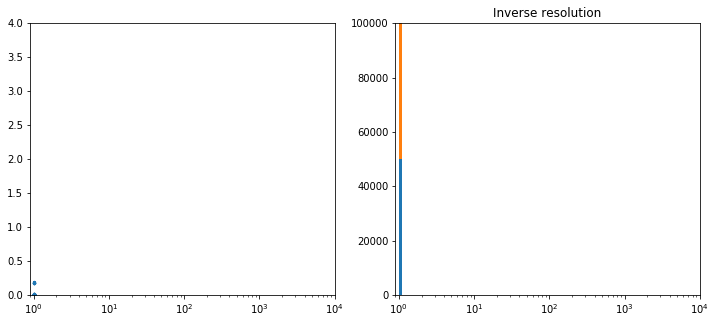

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 38s 75us/sample - loss: 2.5092 - recon_loss: 9.9911 - get_kl_loss: 0.0114 - val_loss: 2.4988 - val_recon_loss: 9.9905 - val_get_kl_loss: 0.0011
Epoch 2/1000
500000/500000 [==============================] - 38s 76us/sample - loss: 2.5011 - recon_loss: 10.0009 - get_kl_loss: 8.7305e-04 - val_loss: 2.4976 - val_recon_loss: 9.9874 - val_get_kl_loss: 7.1830e-04
Epoch 3/1000
500000/500000 [==============================] - 38s 77us/sample - loss: 2.5008 - recon_loss: 10.0006 - get_kl_loss: 6.4506e-04 - val_loss: 2.4980 - val_recon_loss: 9.9897 - val_get_kl_loss: 6.1633e-04
Epoch 4/1000
499400/500000 [============================>.] - ETA: 0s - loss: 2.5005 - recon_loss: 9.9999 - get_kl_loss: 5.3588e-04
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
500000/500000 [==============================] - 39s 77us/sample - loss: 2.5006 - recon_loss: 10.0002

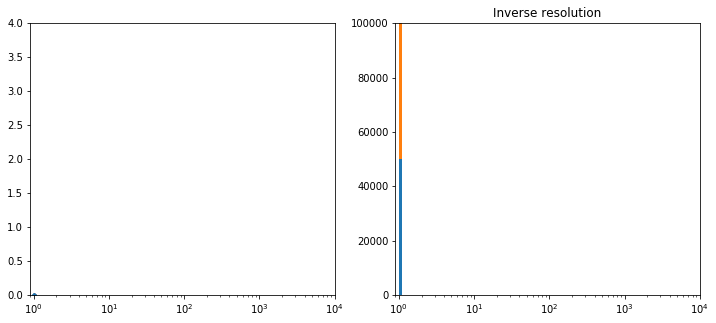

In [23]:
betas = np.array([1e-1,2e-1,4e-1,6e-1,7e-1,8e-1,9e-1,1.,1.1,1.2,1.3,1.4,2.])
sigmas = np.zeros(len(betas))

for i, beta in enumerate(betas):
    min_delta=1e-4/beta**2
    reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks = [modelcheckpoint,reduceLR,earlystop]

    K.set_value(vae.optimizer.lr,1e-5)
    epochs = 1000
    history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                    epochs=epochs,verbose=1,#initial_epoch=history.epoch[-1],
                    validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                    callbacks = callbacks
                  )
    
    sigmas[i] = history.history['val_recon_loss'][-1]
    
    print("Latent space encoding for beta =",beta,":")
    myencoder = encoder_class(encoder)

    plot_latent_space(myencoder,valid_data,xrange = [0.9,1e4])

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 36s 71us/sample - loss: 4.4456 - recon_loss: 9.9925 - get_kl_loss: 0.0046 - val_loss: 4.4400 - val_recon_loss: 9.9791 - val_get_kl_loss: 0.0048
Epoch 2/1000
500000/500000 [==============================] - 37s 73us/sample - loss: 4.4458 - recon_loss: 9.9933 - get_kl_loss: 0.0043 - val_loss: 4.4406 - val_recon_loss: 9.9822 - val_get_kl_loss: 0.0041
Epoch 3/1000
499300/500000 [============================>.] - ETA: 0s - loss: 4.4458 - recon_loss: 9.9947 - get_kl_loss: 0.0037
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
500000/500000 [==============================] - 36s 71us/sample - loss: 4.4458 - recon_loss: 9.9947 - get_kl_loss: 0.0037 - val_loss: 4.4416 - val_recon_loss: 9.9863 - val_get_kl_loss: 0.0033
Epoch 4/1000
500000/500000 [==============================] - 37s 74us/sample - loss: 4.4440 - recon_loss: 9.9924 - get_kl_loss: 0.0030 

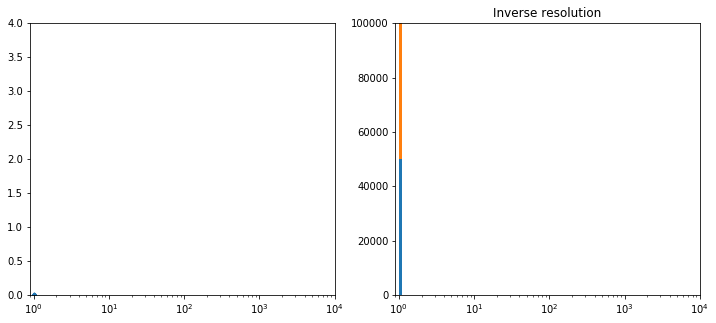

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
500000/500000 [==============================] - 36s 72us/sample - loss: 3.9073 - recon_loss: 9.9980 - get_kl_loss: 0.0018 - val_loss: 3.9046 - val_recon_loss: 9.9905 - val_get_kl_loss: 0.0020
Epoch 2/1000
500000/500000 [==============================] - 37s 74us/sample - loss: 3.9071 - recon_loss: 9.9977 - get_kl_loss: 0.0018 - val_loss: 3.9018 - val_recon_loss: 9.9845 - val_get_kl_loss: 0.0016
Epoch 3/1000
500000/500000 [==============================] - 36s 73us/sample - loss: 3.9071 - recon_loss: 9.9976 - get_kl_loss: 0.0018 - val_loss: 3.9026 - val_recon_loss: 9.9867 - val_get_kl_loss: 0.0015
Epoch 4/1000
499700/500000 [============================>.] - ETA: 0s - loss: 3.9071 - recon_loss: 9.9980 - get_kl_loss: 0.0016
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
500000/500000 [==============================] - 36s 72us/sample - loss: 3.9071 - recon_loss: 9.9982 - get_kl_loss: 0.0016 

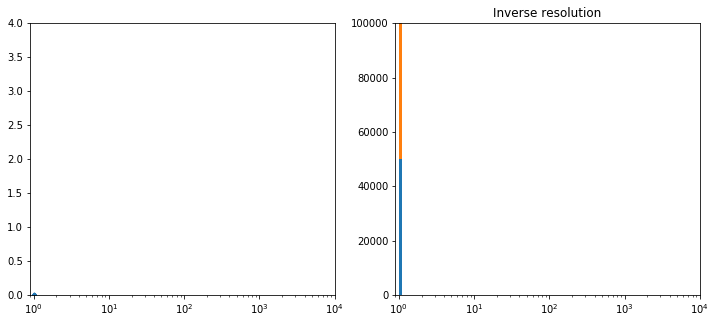

Train on 500000 samples, validate on 50000 samples
Epoch 1/1000
345100/500000 [===================>..........] - ETA: 14s - loss: 3.0892 - recon_loss: 10.0064 - get_kl_loss: 7.7547e-04

KeyboardInterrupt: 

In [53]:
newbetas = np.array([1.5,1.6,1.8,4])
newsigmas = np.zeros(len(betas))
newKLs = np.zeros(len(betas))


for i, beta in enumerate(newbetas):
    min_delta=1e-4/beta**2
    reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks = [modelcheckpoint,reduceLR,earlystop]

    K.set_value(vae.optimizer.lr,1e-5)
    epochs = 1000
    history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                    epochs=epochs,verbose=1,#initial_epoch=history.epoch[-1],
                    validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                    callbacks = callbacks
                  )
    
    newsigmas[i] = history.history['val_recon_loss'][-1]
    newKLs[i] = history.history['val_get_kl_loss'][-1]
    
    print("Latent space encoding for beta =",beta,":")
    myencoder = encoder_class(encoder)

    plot_latent_space(myencoder,valid_data,xrange = [0.9,1e4])

In [51]:
history.history.keys()

dict_keys(['loss', 'recon_loss', 'get_kl_loss', 'val_loss', 'val_recon_loss', 'val_get_kl_loss', 'lr'])

In [54]:
newbetas

array([1.5, 1.6, 1.8, 4. ])

In [55]:
newsigmas

array([9.98272228, 9.98419571, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [56]:
newKLs

array([0.00175833, 0.00095713, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [58]:
KLs

array([2.64889e+01, 1.95552e+01, 1.26222e+01, 8.56390e+00, 7.01540e+00,
       5.69300e+00, 4.52620e+00, 3.46110e+00, 2.50160e+00, 1.63110e+00,
       8.36600e-01, 1.65800e-01, 2.57640e-04])

In [60]:
betas = np.array([0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4,1.5,1.6, 2. ])
sigmas = np.array([0.05076496, 0.20073637, 0.80264813, 1.80077815, 2.4600265 ,3.19967914, 4.05159807, 5.01125669, 6.05772114, 7.20176363,8.44191551, 9.66676617,9.98272228, 9.98419571, 9.98559666])
KLs = np.array([2.64889e+01, 1.95552e+01, 1.26222e+01, 8.56390e+00, 7.01540e+00,5.69300e+00, 4.52620e+00, 3.46110e+00, 2.50160e+00, 1.63110e+00, 8.36600e-01, 1.65800e-01,0.00175833, 0.00095713, 2.57640e-04])

In [61]:
delta_sigmas = np.array([sigmas[i+1] - sigmas[i] for i in range(len(sigmas)-1)])
delta_betasqrs = np.array([betas[i+1]**2 - betas[i]**2 for i in range(len(sigmas)-1)])
delta_KLs = np.array([KLs[i+1] - KLs[i] for i in range(len(sigmas)-1)])
delta_log_betas = np.array([2*np.log(betas[i+1]/betas[i]) for i in range(len(betas) - 1)])

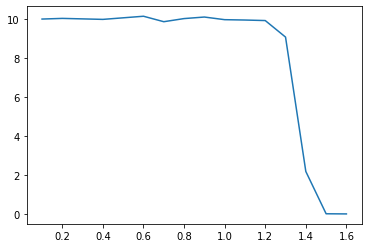

In [62]:
plt.plot(betas[:-1],delta_sigmas/delta_betasqrs*2)
plt.show()

In [65]:
delta_KLs = np.array([KLs[i+1] - KLs[i] for i in range(len(sigmas)-1)])

In [66]:
delta_log_betas = np.array([2*np.log(betas[i+1]/betas[i]) for i in range(len(betas) - 1)])

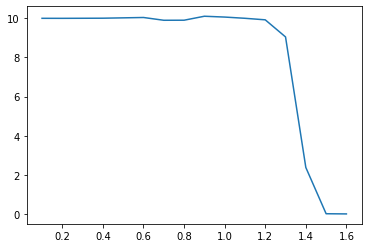

In [68]:
plt.plot(betas[:-1],-delta_KLs/delta_log_betas*2)
plt.show()

In [124]:
betas = np.array([0.005,0.0065,0.0085,0.0112,0.0146,0.0191,0.025,0.033,0.043,0.086,0.172,0.243,0.344,0.486,0.688,0.973,1.38,1.95])
sigmas = np.array([0.10419,0.11310,0.12536,0.14185,0.16060,0.17956,0.19117,0.20105,0.21368,0.27250,0.40850,0.52698,0.70041,0.94654,1.25582,1.42903,1.55463,1.6276])
KLs = np.array([0.06593,0.07582,0.08549,0.09397,0.10174,0.11184,0.13341,0.16516,0.20153,0.32423,0.46751,0.52121,0.53454,0.46651,0.27023,0.17747,0.09841,4.9024E-02])/betas

In [125]:
delta_sigmas = np.array([sigmas[i+1] - sigmas[i] for i in range(len(sigmas)-1)])
delta_sigmasqr = np.array([sigmas[i+1]**2 - sigmas[i]**2 for i in range(len(sigmas)-1)])
delta_betas = np.array([betas[i+1] - betas[i] for i in range(len(sigmas)-1)])
betasigmas = betas*sigmas
delta_betasigmas = np.array([betasigmas[i+1] - betasigmas[i] for i in range(len(sigmas)-1)])
delta_KLs = np.array([KLs[i+1] - KLs[i] for i in range(len(sigmas)-1)])
delta_log_betas = np.array([np.log(betas[i+1]/betas[i]) for i in range(len(betas) - 1)])
delta_log_betasigmas = np.array([0.5*np.log(betasigmas[i+1]/betasigmas[i]) for i in range(len(betas) - 1)])

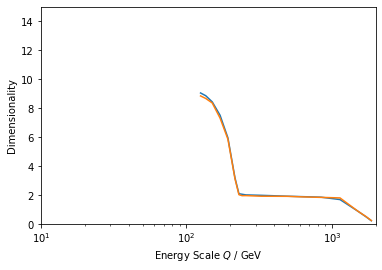

In [138]:
plt.plot(sigmas[:-1]*600*2,delta_sigmasqr/delta_betasigmas)
plt.plot(sigmas[:-1]*600*2,-delta_KLs/delta_log_betasigmas)
plt.semilogx()
plt.xlim([10,2*10**3])
plt.ylim([0,15])
plt.xlabel(r"Energy Scale $Q$ / GeV")
plt.ylabel("Dimensionality")
plt.show()

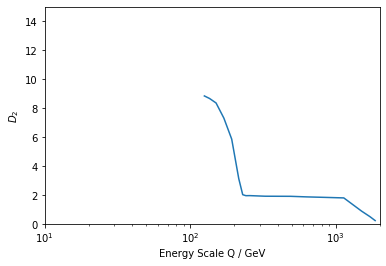

In [135]:
plt.plot(sigmas[:-1]*600*2,-delta_KLs/delta_log_betasigmas)
plt.semilogx()
plt.xlim([10,2*10**3])
plt.ylim([0,15])
plt.xlabel("Energy Scale Q / GeV")
plt.ylabel(r"$D_2$")
plt.show()

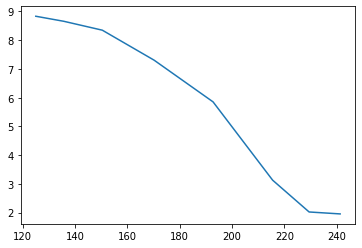

In [98]:
plt.plot(sigmas[:-1]*600*2,-delta_KLs/delta_log_betasigmas)
plt.show()

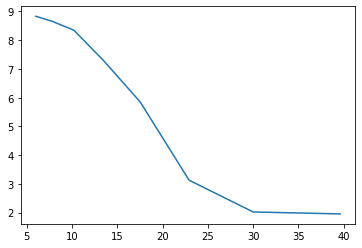

In [103]:
plt.plot(betas[:-1]*600*2,-delta_KLs/delta_log_betasigmas)
plt.show()

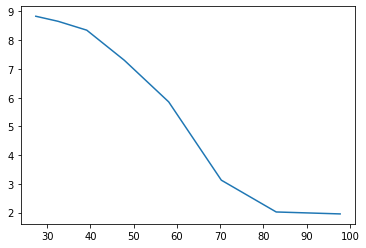

In [123]:
plt.plot(np.sqrt(betasigmas[:-1])*600*2,-delta_KLs/delta_log_betasigmas)
plt.show()